In [62]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [63]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt

# Load the feature files and combine the features
features_s1_s2 = pd.read_csv('../GSEA/miRNA/50_s1_s2.csv')['Feature'].tolist()
features_s2_s3 = pd.read_csv('../GSEA/miRNA/50_s2_s3.csv')['Feature'].tolist()
features_s3_s4 = pd.read_csv('../GSEA/miRNA/50_s3_s4.csv')['Feature'].tolist()

all_selected_features = list(set(features_s1_s2 + features_s2_s3 + features_s3_s4))

print(len(all_selected_features))  # Ensure the total number of unique features

62


In [64]:
# Load and prepare the original stage data
stage_1_samples = pd.read_csv('../data/cancer/stage_1_prostate_cancer_samples.csv')
stage_2_samples = pd.read_csv('../data/cancer/stage_2_prostate_cancer_samples.csv')
stage_3_samples = pd.read_csv('../data/cancer/stage_3_prostate_cancer_samples.csv')
stage_4_samples = pd.read_csv('../data/cancer/stage_4_prostate_cancer_samples.csv')

# Add stage column for easier concatenation
stage_1_samples['Stage'] = 'Stage 1'
stage_2_samples['Stage'] = 'Stage 2'
stage_3_samples['Stage'] = 'Stage 3'
stage_4_samples['Stage'] = 'Stage 4'

In [65]:

# Combine all stages data
combined_data = pd.concat([stage_1_samples, stage_2_samples, stage_3_samples, stage_4_samples], ignore_index=True)

# Ensure only numeric columns are used
numeric_columns = combined_data.columns.drop(['Sample_ID', 'Sex', 'Age', 'Stage', 'Disease'])

# Calculate the average expression levels for each miRNA for each stage
average_expression = combined_data.groupby('Stage')[numeric_columns].mean().T

# Ensure all selected features are present in the data
selected_features_in_data = [feature for feature in all_selected_features if feature in average_expression.index]

print("Features present in data:", len(selected_features_in_data))

# Print missing features
missing_features = set(all_selected_features) - set(selected_features_in_data)
if missing_features:
    print("Missing features:", missing_features)

# Extract the selected features from the average expression data
selected_expression = average_expression.loc[selected_features_in_data]

# Normalize each miRNA across stages
normalized_expression = selected_expression.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Check if the normalization removes any miRNAs
print("Normalized expression shape:", normalized_expression.shape)

Features present in data: 62
Normalized expression shape: (62, 4)


<Figure size 1500x1000 with 0 Axes>

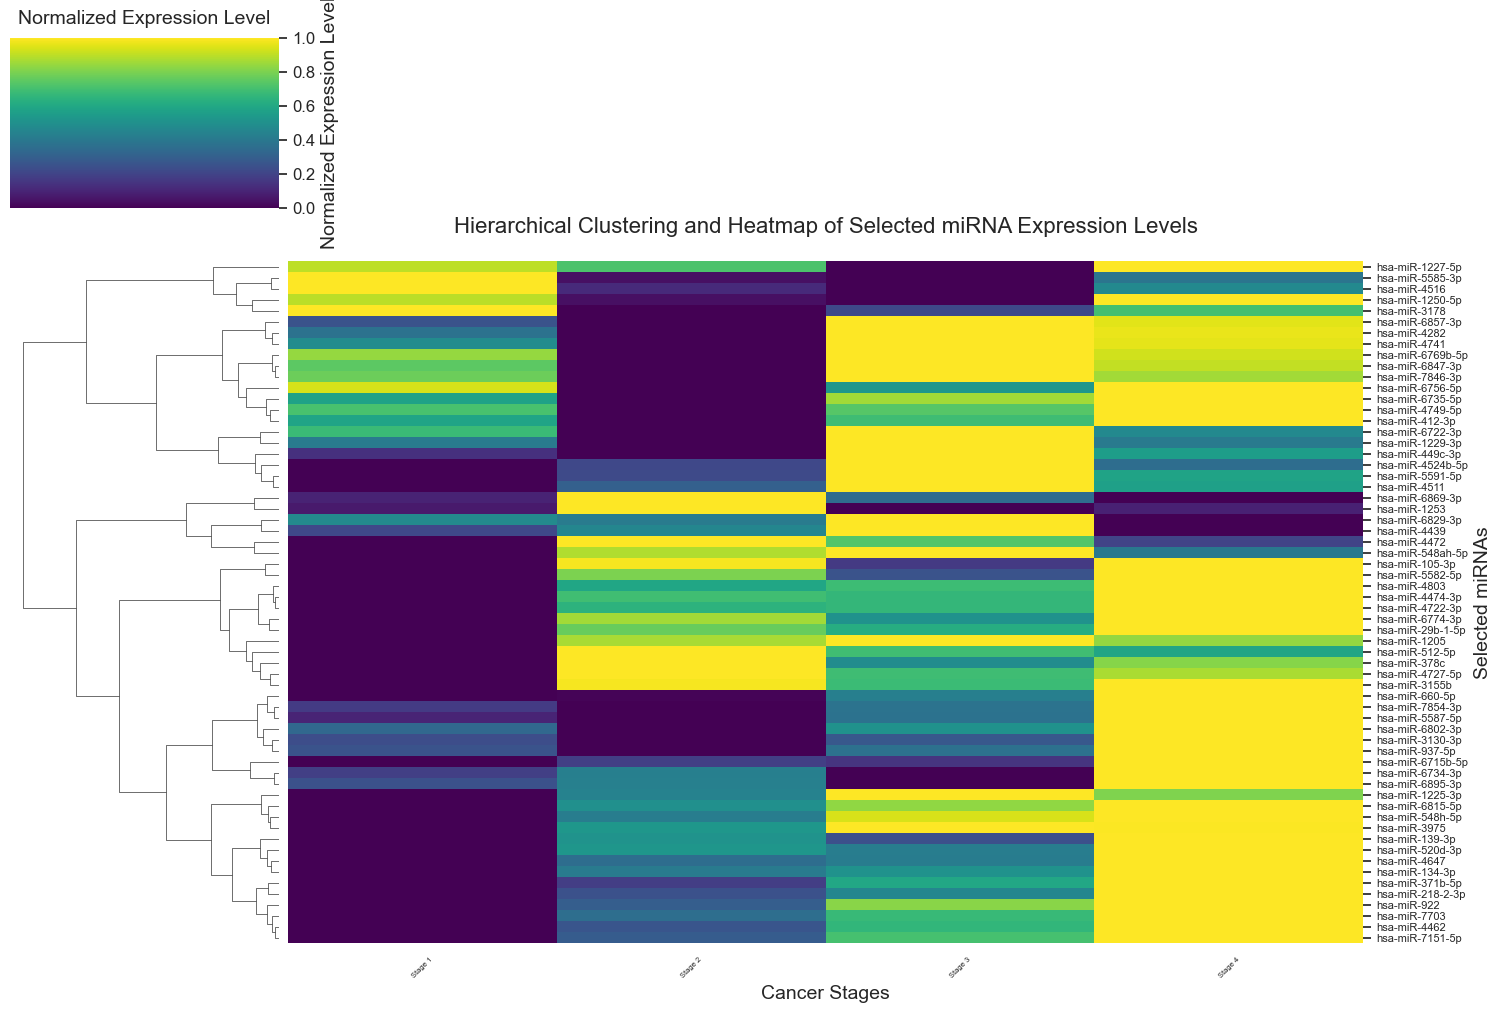

In [66]:
# Perform hierarchical clustering on the normalized data
linked = linkage(normalized_expression, method='ward')

# Create a heatmap with dendrogram
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)  # Reduce font scale for better visibility
clustermap = sns.clustermap(normalized_expression, row_linkage=linked, col_cluster=False, cmap='viridis', figsize=(15, 10))

# Enhance the heatmap
clustermap.ax_heatmap.set_title('Hierarchical Clustering and Heatmap of Selected miRNA Expression Levels', fontsize=16, pad=20)
clustermap.ax_heatmap.set_xlabel('Cancer Stages', fontsize=14)
clustermap.ax_heatmap.set_ylabel('Selected miRNAs', fontsize=14)
clustermap.ax_heatmap.tick_params(axis='x', rotation=45)

# Set y-tick labels to ensure all miRNAs are displayed
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8)  # Adjust fontsize for y-tick labels

# Add color bar legend with a title
cbar = clustermap.ax_heatmap.collections[0].colorbar
cbar.set_label('Normalized Expression Level', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set color bar title
cbar.ax.set_title('Normalized Expression Level', fontsize=14, pad=10)

plt.tight_layout()

# Save the figure
# plt.savefig('../data/heatmap_clustering_normalized_all_features.png')
plt.show()

- For each of the 7 different groups from hierarchical clustering, choose one miRNA and perform analysis on it to give a sample from that group
	- ANOVA Statistical Analysis
	- Post HOC Analysis
	- Plot expression over groups using bar plot

## Random Sampling From the 7 Clusters

In [67]:
# import pandas as pd
# import seaborn as sns
# from scipy.cluster.hierarchy import fcluster
# from scipy.stats import f_oneway
# import matplotlib.pyplot as plt
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Assign clusters
# num_clusters = 7
# clusters = fcluster(linked, num_clusters, criterion='maxclust')

# # Sample one miRNA from each cluster
# sampled_miRNAs = []
# for cluster_id in range(1, num_clusters + 1):
#     cluster_miRNAs = normalized_expression.index[clusters == cluster_id]
#     sampled_miRNA = cluster_miRNAs[0]  # Select the first miRNA in the cluster
#     sampled_miRNAs.append(sampled_miRNA)

# print("Sampled miRNAs from each cluster:", sampled_miRNAs)

# # Perform ANOVA and Post Hoc analysis on normalized data
# for miRNA in sampled_miRNAs:
#     miRNA_data = combined_data[['Stage', miRNA]]
#     miRNA_data = miRNA_data.dropna()

#     # Normalize within each miRNA across all stages
#     miRNA_data['Normalized'] = miRNA_data.groupby('Stage')[miRNA].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

#     # ANOVA on normalized data
#     anova_result = f_oneway(
#         miRNA_data[miRNA_data['Stage'] == 'Stage 1']['Normalized'],
#         miRNA_data[miRNA_data['Stage'] == 'Stage 2']['Normalized'],
#         miRNA_data[miRNA_data['Stage'] == 'Stage 3']['Normalized'],
#         miRNA_data[miRNA_data['Stage'] == 'Stage 4']['Normalized']
#     )

#     print(f"ANOVA result for {miRNA}: F={anova_result.statistic}, p={anova_result.pvalue}")

#     # Post Hoc Analysis with Tukey HSD on normalized data
#     tukey_result = pairwise_tukeyhsd(endog=miRNA_data['Normalized'], groups=miRNA_data['Stage'], alpha=0.05)
#     print(tukey_result)

#     # Plot normalized expression over groups using bar plot
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x='Stage', y='Normalized', data=miRNA_data, ci='sd')
#     plt.title(f'Normalized Expression of {miRNA} across Cancer Stages')
#     plt.xlabel('Cancer Stages')
#     plt.ylabel('Normalized Expression Level')
#     plt.tight_layout()
#     plt.show()

## Specific Sampling from the 7 Clusters

ANOVA result for hsa-miR-3178: F=99.81007169517846, p=6.207903134277661e-55
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Stage 1 Stage 2   0.2328    0.0  0.1974  0.2682   True
Stage 1 Stage 3   0.1269    0.0  0.0835  0.1702   True
Stage 1 Stage 4   0.1108    0.0  0.0605  0.1611   True
Stage 2 Stage 3  -0.1059    0.0 -0.1432 -0.0687   True
Stage 2 Stage 4   -0.122    0.0 -0.1672 -0.0768   True
Stage 3 Stage 4  -0.0161 0.8543 -0.0677  0.0356  False
------------------------------------------------------


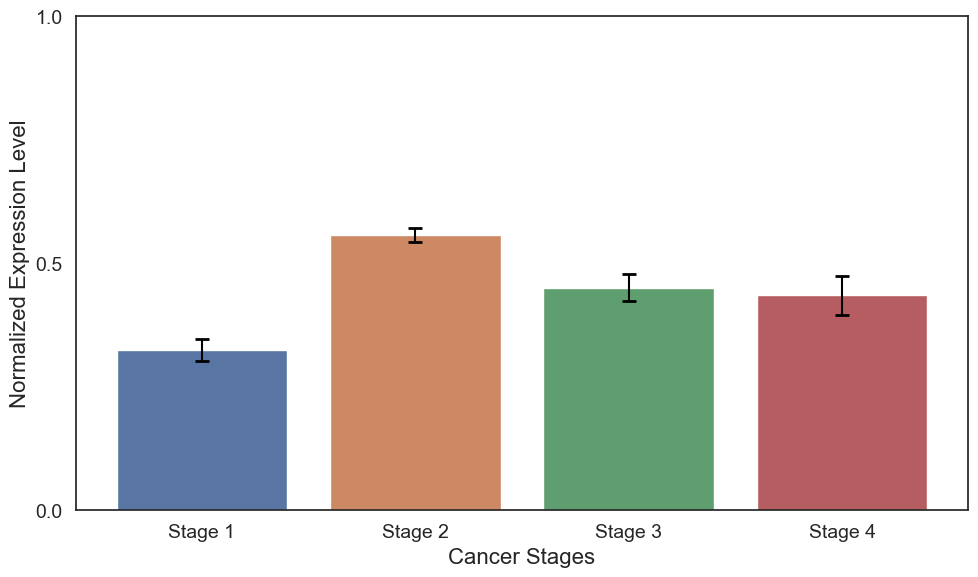

ANOVA result for hsa-miR-7846-3p: F=51.499495924552996, p=1.8684132432922205e-30
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Stage 1 Stage 2  -0.0538    0.0 -0.0844 -0.0232   True
Stage 1 Stage 3    0.083    0.0  0.0455  0.1205   True
Stage 1 Stage 4    0.071 0.0002  0.0275  0.1145   True
Stage 2 Stage 3   0.1368    0.0  0.1046   0.169   True
Stage 2 Stage 4   0.1248    0.0  0.0858  0.1639   True
Stage 3 Stage 4   -0.012 0.8997 -0.0566  0.0326  False
------------------------------------------------------


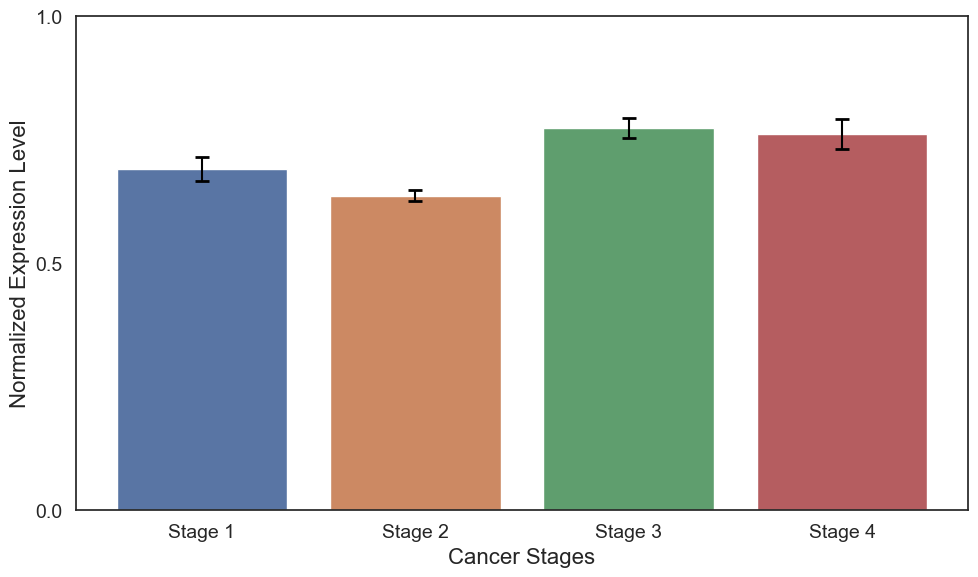

ANOVA result for hsa-miR-5591-5p: F=1.396046569411289, p=0.24268454490199037
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Stage 1 Stage 2  -0.0052 0.9942 -0.0579 0.0475  False
Stage 1 Stage 3    0.036  0.476 -0.0284 0.1004  False
Stage 1 Stage 4   0.0209 0.8888 -0.0538 0.0957  False
Stage 2 Stage 3   0.0412 0.2228 -0.0142 0.0966  False
Stage 2 Stage 4   0.0261 0.7482  -0.041 0.0933  False
Stage 3 Stage 4   -0.015  0.958 -0.0918 0.0617  False
-----------------------------------------------------


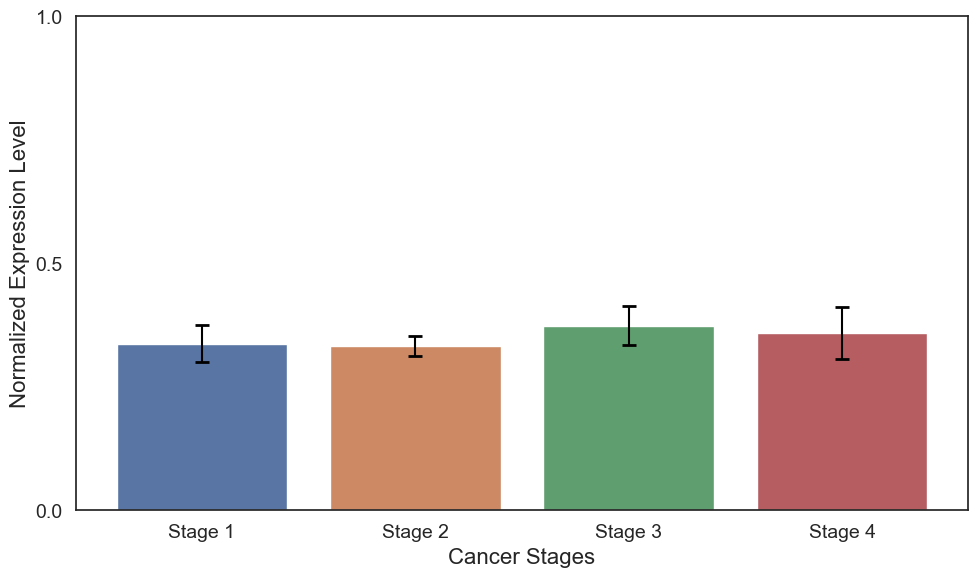

ANOVA result for hsa-miR-548ah-5p: F=4.843700378849166, p=0.002396519256204451
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Stage 1 Stage 2   0.0366 0.0381  0.0014 0.0718   True
Stage 1 Stage 3    0.062 0.0013  0.0189 0.1051   True
Stage 1 Stage 4   0.0427 0.1244 -0.0073 0.0927  False
Stage 2 Stage 3   0.0254 0.2908 -0.0116 0.0624  False
Stage 2 Stage 4   0.0061 0.9851 -0.0388  0.051  False
Stage 3 Stage 4  -0.0193 0.7683 -0.0706  0.032  False
-----------------------------------------------------


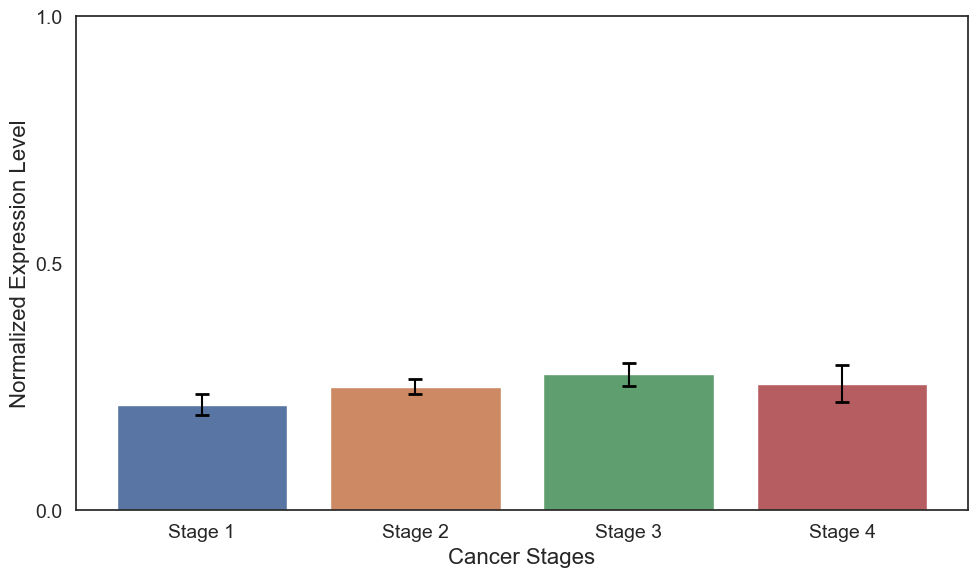

ANOVA result for hsa-miR-4474-3p: F=13.989210486466726, p=6.748288645363338e-09
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Stage 1 Stage 2   -0.061 0.0085 -0.1105 -0.0115   True
Stage 1 Stage 3   0.0474 0.1828 -0.0131   0.108  False
Stage 1 Stage 4   0.0518 0.2305 -0.0185   0.122  False
Stage 2 Stage 3   0.1084    0.0  0.0564  0.1605   True
Stage 2 Stage 4   0.1128    0.0  0.0497  0.1759   True
Stage 3 Stage 4   0.0043 0.9987 -0.0678  0.0765  False
------------------------------------------------------


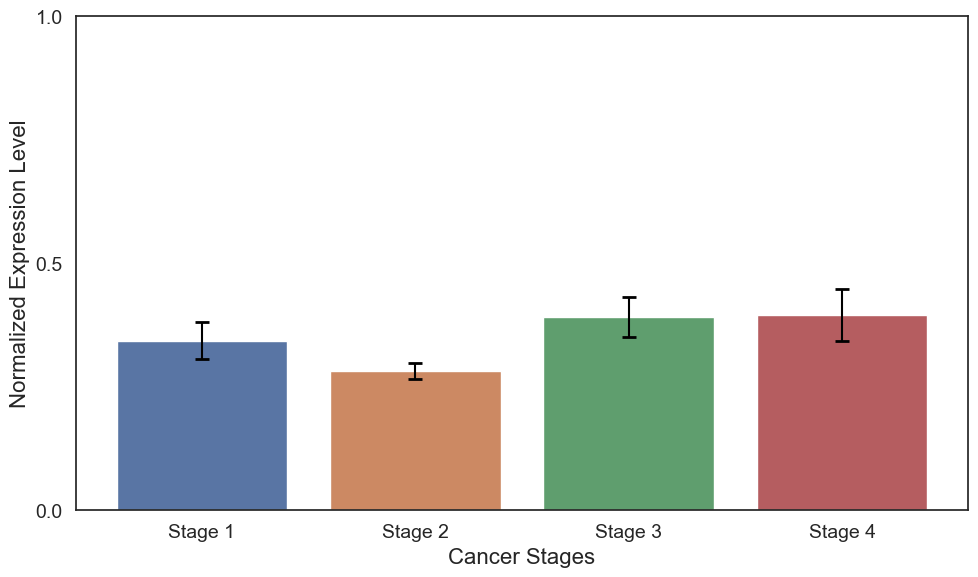

ANOVA result for hsa-miR-937-5p: F=35.292117890095504, p=1.9605127490209066e-21
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Stage 1 Stage 2   0.1257    0.0    0.09  0.1613   True
Stage 1 Stage 3   0.1542    0.0  0.1106  0.1979   True
Stage 1 Stage 4   0.0885    0.0  0.0379  0.1392   True
Stage 2 Stage 3   0.0286 0.2036 -0.0089  0.0661  False
Stage 2 Stage 4  -0.0371 0.1535 -0.0826  0.0084  False
Stage 3 Stage 4  -0.0657 0.0065 -0.1177 -0.0137   True
------------------------------------------------------


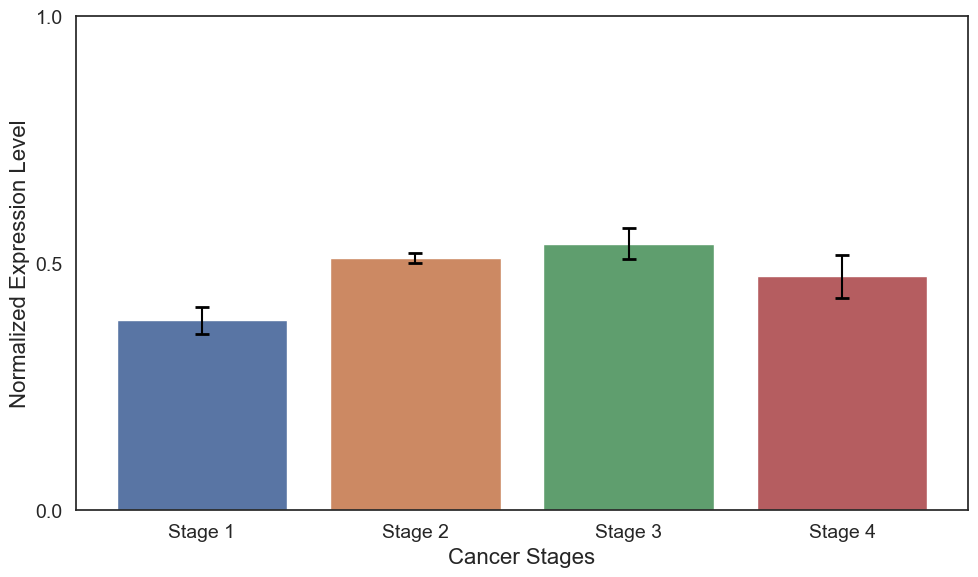

ANOVA result for hsa-miR-4462: F=11.736649500778231, p=1.566553862732768e-07
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Stage 1 Stage 2  -0.0235 0.1198 -0.0509  0.0038  False
Stage 1 Stage 3  -0.0743    0.0 -0.1077 -0.0408   True
Stage 1 Stage 4  -0.0413 0.0321 -0.0801 -0.0025   True
Stage 2 Stage 3  -0.0507    0.0 -0.0795  -0.022   True
Stage 2 Stage 4  -0.0178 0.5561 -0.0526  0.0171  False
Stage 3 Stage 4    0.033 0.1443 -0.0069  0.0728  False
------------------------------------------------------


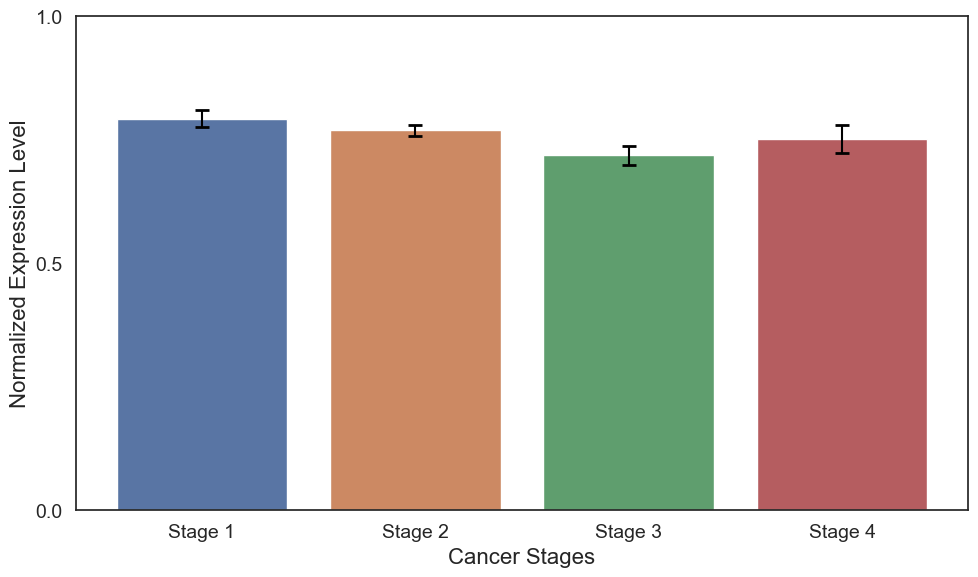

In [83]:
# List of specific miRNAs to analyze
miRNAs_to_analyze = ['hsa-miR-3178', 'hsa-miR-7846-3p', 'hsa-miR-5591-5p', 'hsa-miR-548ah-5p', 'hsa-miR-4474-3p', 'hsa-miR-937-5p', 'hsa-miR-4462']

sns.set_style("white")

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('font', size=14)     

# Perform ANOVA and Post Hoc analysis on specified miRNAs
for miRNA in miRNAs_to_analyze:
    miRNA_data = combined_data[['Stage', miRNA]]
    miRNA_data = miRNA_data.dropna()

    # Normalize within each miRNA across all stages
    miRNA_data['Normalized'] = miRNA_data.groupby('Stage')[miRNA].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    # ANOVA on normalized data
    anova_result = f_oneway(
        miRNA_data[miRNA_data['Stage'] == 'Stage 1']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 2']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 3']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 4']['Normalized']
    )

    print(f"ANOVA result for {miRNA}: F={anova_result.statistic}, p={anova_result.pvalue}")

    # Post Hoc Analysis with Tukey HSD on normalized data
    tukey_result = pairwise_tukeyhsd(endog=miRNA_data['Normalized'], groups=miRNA_data['Stage'], alpha=0.05)
    print(tukey_result)

    mean_data = miRNA_data.groupby('Stage')['Normalized'].mean().reset_index()
    sem_data = miRNA_data.groupby('Stage')['Normalized'].sem().reset_index()
    mean_data['2*SEM'] = 2 * sem_data['Normalized']

    # Plot normalized expression over groups using bar plot
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='Stage', y='Normalized', data=mean_data)
    
    # Add error bars with horizontal caps
    for i, stage in enumerate(mean_data['Stage']):
        plt.errorbar(x=i, y=mean_data.loc[i, 'Normalized'], yerr=mean_data.loc[i, '2*SEM'], fmt='none', c='black', capsize=5, capthick=2)

    plt.xlabel('Cancer Stages')
    plt.ylabel('Normalized Expression Level')
    plt.yticks([0, 0.5, 1])
    plt.tight_layout()
    plt.show()